[Home](home.ipynb) > Generative Models > Generalized Barabási–Albert Model

<img style='float: left;' src='https://www.gesis.org/fileadmin/styles/img/gs_home_logo_en.svg'>

### *Notebooks for Computational Sociology*

# Generalized Barabási–Albert Model: Generating random networks with different degree distributions
Author: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

Version: 0.9 (17.07.2019)

Please cite as: Lietz, Haiko (2019). Generalized Barabási–Albert Model: Generating random networks with different degree distributions. Version 0.9 (17.07.2019). *Notebooks for Computational Sociology*. GESIS. url:xxx

<div class="alert alert-info">
<big><b>Significance</b></big>

The Barabási–Albert Model is a very simple but fundamental algorithm that generates random networks where the number of neighbors per node can be very heterogeneous. Existing nodes attract new edges with a cumulative advantage. This rich-get-richer mechanism resembles the Matthew Effect. The generalized model allows for tuning the extent to which cumulative advantage is effective and for specifying the intrinsic attractiveness (fitness) of nodes. The generative model is minimal and can be applied to explain inequality in complex systems.
</div>

## Introduction
Network generators consist of simple mechanisms or rules how nodes or links are to be attached to an initial network. One of the most basic mechanisms involves the *rich-get-richer effect* according to which a node's chance to acquire a new link is proportional to the number of links that node already has. Such an effect was described by [Merton (1968)](https://doi.org/10.1126/science.159.3810.56) for the accumulation of reward in the science systeme and termed the *Matthew Effect*, following the Gospel According to St. Matthew which says:

> For unto every one that hath shall be given, and he shall have abundance: but from him that hath not shall be taken away even that which he hath.

This effect generates power-law distributions of quantity. A related mechanism was first proposed by [Yule (1925)](https://doi.org/10.1098/rstb.1925.0002) to explain the structure of the tree of life. [Simon (1955)](https://doi.org/10.2307/2333389) studied another variant which he called the *Gibrat principle* to explain power-law distributions in society, biology, and the economy. [Price (1976)](https://doi.org/10.1002/asi.4630270505) mathematically introduced the first generator of directed networks with power-law indegree distributions and coined the term of a *cumulative advantage*.

[Barabási & Albert (1999)](https://doi.org/10.1126/science.286.5439.509) discovered power-law effects in complex social and technological networks. Unaware of preceeding models, they introduced a model which formally combines network *growth* and *preferential attachment*, the latter being their term for the rich-get-richer mechanism, to generate undirected random networks with a power-law degree distribution. [Bollobás et al. (2001)](https://doi.org/10.1002/rsa.1009) proved that this mechanism genrates scale-free networks with $p(k)\propto k^{-3}$, where $k$ is a node's degree (number of neighbors). The so-called BA Model remains one of the most fundamental network generators to date.

In the BA Model, the oldest nodes will also turn out to have the largest degrees when the growth process is over. This clashes with the observation that, in reality, new nodes can be much more attractive that old nodes (e.g., the Google search engine is much more popular than the Yahoo search engine, even though the latter is much older). This caused [Bianconi & Barabási (2001)](https://doi.org/10.1209/epl/i2001-00260-6) to introduce a fitness parameter that amplifies or dampens the Matthew Effect.

**In this notebook**, I provide an intuitive walk through the construction of the BA Model. In my code, target vertices are sampled using roulette wheel selection described below. I discuss the *Generalized BA Model* with a tunable attachment exponent $\gamma$ and a fitness parameter $\eta$. The probability of a new node to attach to an existing node $i$ is

\begin{equation}
    \Pi_i=\frac{\eta_i k_i^\gamma}{\sum_j{\eta_j k_j^\gamma}},
\end{equation}

*i.e.*, it is proportional to a node's fitness $\eta_i$ multiplied by its degree $k_i$ raised to the power of $\gamma$. For the special case of $\eta_i=1$, [Krapivsky *et al.* (2000)](https://doi.org/10.1103/PhysRevLett.85.4629) have demonstrated that the degree distribution $p(k)$ is a power law for $\gamma=1$. For $0<\gamma<1$ it takes the form of a stretched exponential. For $\gamma>1$ very few nodes run away with all the new links and the generated networks are very star-like. For the special case of $\gamma=1$, [Bianconi & Barabási (2001)](https://doi.org/10.1209/epl/i2001-00260-6) have found that $p(k)$ resembles a power law when $\eta_i$ is distributed uniformly in $[0,1]$. It has a stretched-exponential form when $\eta_i$ is normally distributed.

## Dependencies and Settings

In [10]:
%matplotlib inline

In [11]:
import networkx as nx
import random as rd
import matplotlib.pyplot as plt
import warnings

In [12]:
warnings.filterwarnings('ignore')

## Model

``ba_model()`` is the main function to generate a random network. ``n`` sets the size of the desired network and ``c`` is the attachment exponent $\gamma$. ``G`` is an arbitrary graph that can be grown using these parameter settings. If a ``seed`` is given, the same network can reproduced with the same seed.

If a graph is to be generated from scratch (line 4), an empty undirected graph object ``G`` is created (line 5), an edge is set among the initial two vertices (line 6), and the identifier ``source`` of the next vertex to be attached to ``G`` is set to 2 (line 7).

If an existing graph ``G`` is to be grown (line 8), only ``source`` needs to be set (line 9).

Now preferential attachment comes into play. While ``G`` has not reached its desired size ``n`` (line 10), a vertex ``target`` is sampled from ``G`` using the attachment parameter ``c`` by calling the function ``sample_target_vertex()`` (line 11). An edge is added between the existing target vertex and the new source vertex (line 12) and the next source is set (line 13).

In [4]:
def ba_model_nx(n, c, G=None, Seed=None):
    from random import seed
    if Seed is not None:
        seed(Seed)
    from networkx import Graph
    if G == None:
        G = Graph()
        G.add_edge(0, 1)
        source = 2
    else:
        source = len(G)
    from compsoc import sample_target_vertex
    while source < n:
        target = sample_target_vertex(c, G)
        G.add_edge(target, source)
        source += 1
    return G

``sample_target_vertex()`` samples a vertex from graph ``G`` proportional to that vertex's degree raised to the power of ``c``. *Roulette wheel selection* means that sampling can be imagined similar to a roulette wheel in a casino where a proportion of the wheel is assigned to each vertex. First all degrees are stored in a dictionary that contains vertex identifiers as keys and degrees as values (line 2). To assign proportions of the wheel to the vertices, the values in the dictionary are replaced by the cumulative degrees raised to the power of ``c`` (lines 3-5). Then the target vertex is sampled by calling the ``sample()`` function.

In [5]:
def sample_target_vertex(c, G):
    d = dict(G.degree())
    d[0] = d[0]**c
    for i in range(1, len(d)):
        d[i] = d[i-1]+d[i]**c
    from compsoc import sample
    target = sample(d)
    return target

``sample()`` returns a key (vertex identifier) from the input dictionary ``d``. This function resembles the ball coming to rest on the roulette wheel. First the proportion (value) of the wheel (dictionary) is randomly selected (line 2). If a seed has been set in the main ``ba_model()`` function, it will be used here. Then the key corresponding to the randomly selected value is identified (lines 3-5).

In [6]:
def sample(d):
    from random import random
    r = random()*d[len(d)-1]
    i = 0
    while d[i] < r:
        i += 1
    return i

These three functions are included in the ``compsoc`` library to be called in other notebooks.

## Results

In [19]:
G = ba_model_nx(c=1.0, n=10, G=None, Seed=0)

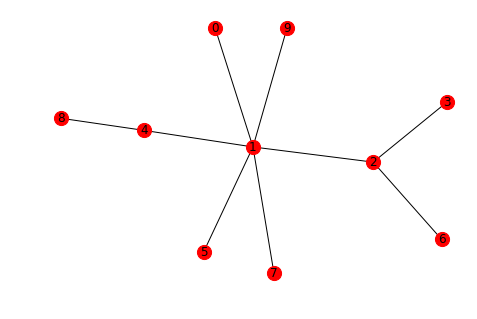

In [20]:
nx.draw_spring(G, with_labels=True, node_size=200)

### Degree Distribution

In [9]:
k = [degree for (node, degree) in list(G.degree())]

(array([78., 12.,  6.,  1.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

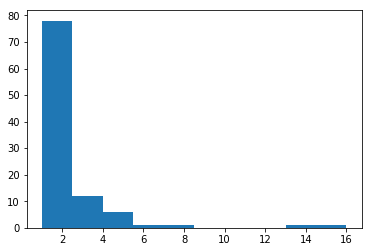

In [10]:
plt.hist(k)

## Acknowledgement
The code of this network generator is inspired by Nataša Kejžar's code for the feedback model.

## Literature
Barabási, A.-L. & Albert, R. (1999). Emergence of scaling in random networks. *Science*, *286*(5439), 509–512. doi:[10.1126/science.286.5439.509](https://doi.org/10.1126/science.286.5439.509)

Bianconi, G. & Barabási, A.-L. (2001). Competition and multiscaling in evolving networks. *EPL (Europhysics Letters)*, *54*(4), 436–442. doi:[10.1209/epl/i2001-00260-6](https://doi.org/10.1209/epl/i2001-00260-6)

Bollobás, B., Riordan, O., Spencer, J., & Tusnády, G. (2001). The degree sequence of a scale‐free random graph process. *Random Structures & Algorithms*, *18*(3), 279–290. doi:[10.1002/rsa.1009](https://doi.org/10.1002/rsa.1009)

Krapivsky, P. L., Redner, S., & Leyvraz, F. (2000). Connectivity of growing random networks. *Physical Review Letters*, *85*(21), 4629–4632. doi:[10.1103/PhysRevLett.85.4629](https://doi.org/10.1103/PhysRevLett.85.4629)

Merton, R. K. (1968). The Matthew Effect in science. *Science*, *159*(3810), 56–63. doi:[10.1126/science.159.3810.56](https://doi.org/10.1126/science.159.3810.56)

Price, D. J. d. S. (1976). A general theory of bibliometric and other cumulative advantage processes. *Journal of the American Society for Information Science*, *27*(5), 292–306. doi:[10.1002/asi.4630270505](https://doi.org/10.1002/asi.4630270505)

Simon, H. A. (1955). On a class of skew distribution functions. *Biometrika*, *42*(3/4), 425–440. doi:[10.2307/2333389](https://doi.org/10.2307/2333389)

Yule, G. U. (1925). A mathematical theory of evolution, based on the conclusions of Dr. J. C. Willis, F.R.S. *Philosophical Transactions of the Royal Society B*, *213*, 21–87. doi:[10.1098/rstb.1925.0002](https://doi.org/10.1098/rstb.1925.0002)